In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stat
import scipy.io as scipio
import matplotlib.pyplot as plt
%matplotlib inline
import plotly as ly
import datetime
import mapbox
import folium

## Introduction

The data comes from two separate platforms;
- __Hot Pepper Gourmet__ (hpg): An online booking site that allows users to search and book restaurants, read up on restaurant information, and find restaurant coupons. It is similar to Yelp. It has a website and applications optimized for several smartphones. 
- __AirREGI__ (air): This is used by the restaurant side as an all-in-one POS app. Allows sales and inventory management, as well as reservation control. Similar to Square.

The goal is to predict the total number of visitors for a given restaurant and a given date. 

__Dates__: The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week." The training set omits days where the restaurants were closed.

__Data Files__

- __air_reserve.csv__: This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

- __hpg_reserve.csv__: This file contains reservations made in the hpg system.

- __air_store_info.csv__: This file contains information about select air restaurants. Column names and contents are self-explanatory.

- __hpg_store_info.csv__: This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

- __store_id_relation.csv__: This file allows you to join select restaurants that have both the air and hpg system.

- __ air_visit_data.csv__: This file contains historical visit data for the air restaurants.

- __date_info.csv__: This file gives basic information about the calendar dates in the dataset.

In [12]:
## Load air data
air_reserve = pd.DataFrame(pd.read_csv('data/air_reserve.csv'))
air_store = pd.DataFrame(pd.read_csv('data/air_store_info.csv'))
air_visit = pd.DataFrame(pd.read_csv('data/air_visit_data.csv'))
## Load hpg data
hpg_reserve = pd.DataFrame(pd.read_csv('data/hpg_reserve.csv'))
hpg_store = pd.DataFrame(pd.read_csv('data/hpg_store_info.csv'))
## Load other data
store_id =  pd.DataFrame(pd.read_csv('data/store_id_relation.csv'))
date_info = pd.DataFrame(pd.read_csv('data/date_info.csv'))

In [5]:
## Convert visit_date column from str to datetime timestamp
air_visit['visit_date'] = air_visit['visit_date'].\
apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [8]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [9]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [6]:
## Check convert
type(air_visit['visit_date'][0])

pandas._libs.tslib.Timestamp

### Where are the restaurants?

In [5]:
# both air_store and hpg_store have latitude longitude cols

# Map of AirReg Restaurants
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
 
for i in range(0,len(air_store)):
    folium.Marker([air_store.iloc[i]['latitude'], air_store.iloc[i]['longitude']], \
                  popup=air_store.iloc[i]['air_store_id']).add_to(m)

m.fit_bounds([[50,145],[30, 140]])
# m.save('airREG_latlong.html')

In [6]:
%%html 
<a href="airREG_latlong.html">JapanRestMap</a> ## here's a link to the map

In [7]:
m ## folium maps don't show up on github unfortunately

In [9]:
# both air_store and hpg_store have latitude longitude cols

m2 = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
 
## plot HPF restaurants
for i in range(0,len(air_store)):
    folium.Marker([hpg_store.iloc[i]['latitude'], hpg_store.iloc[i]['longitude']], \
                  popup=air_store.iloc[i]['air_store_id']).add_to(m2)

m2.fit_bounds([[50,145],[30, 140]])
# m2.save('HPG_latlong.html')

In [10]:
%%html 
<a href="HPG_latlong.html">JapanRestMap</a> ## here's a link to the map

In [11]:
m2 ## folium maps don't show up on github unfortunately

## Daily Visitors

In [12]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [13]:
air_visit['visit_date'][0]

Timestamp('2016-01-13 00:00:00')

In [14]:
air_visit.groupby(['air_store_id']).mean().head()

,visitors
air_store_id,
air_00a91d42b08b08d9,26.081897
air_0164b9927d20bcc3,9.248322
air_0241aa3964b7f861,9.896465
air_0328696196e46f18,7.939655
air_034a3d5b40d5b1b1,14.828685


(-5, 200)

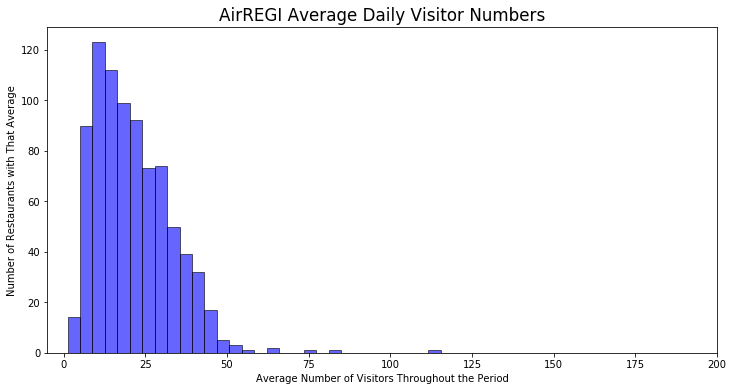

In [15]:
### hist the average daily visitor numbers 
plt.figure(figsize=(12,6))
plt.hist(air_visit.groupby(['air_store_id']).mean()['visitors'],bins=30, color='b', alpha=0.6, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('AirREGI Average Daily Visitor Numbers')
plt.xlabel('Average Number of Visitors Throughout the Period')
plt.ylabel('Number of Restaurants with That Average')
plt.xlim(-5, 200)

In [17]:
hpg_reserve['visit_datetime'] = hpg_reserve['visit_datetime'].\
apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [19]:
hpg_reserve['date'] = hpg_reserve['visit_datetime'].apply(lambda x: x.date())
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,date
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01


(-2, 60)

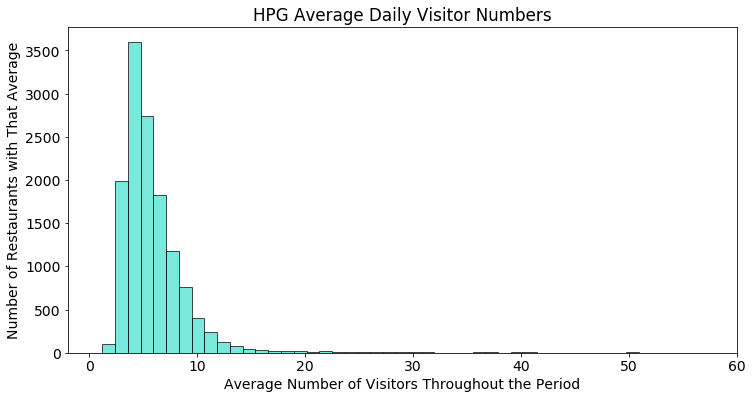

In [20]:
### hist the average daily visitor numbers 
plt.figure(figsize=(12,6))
plt.hist(hpg_reserve.groupby(['hpg_store_id']).mean()['reserve_visitors'],bins=70, color='turquoise', alpha=0.7, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('HPG Average Daily Visitor Numbers')
plt.xlabel('Average Number of Visitors Throughout the Period')
plt.ylabel('Number of Restaurants with That Average')
plt.xlim(-2, 60)

In [21]:
hpg_reserve = hpg_reserve.set_index(['date', 'hpg_store_id'], drop=False)

In [23]:
len(hpg_reserve)

2000320

In [24]:
len(list(set(hpg_reserve['hpg_store_id'])))

13325

(-5, 60)

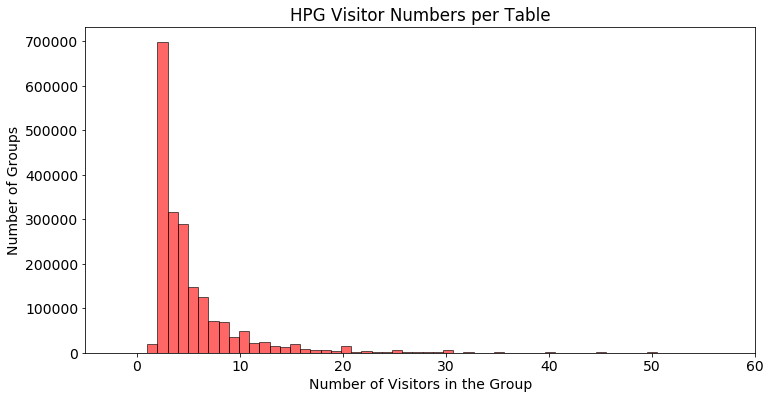

In [26]:
## Plot the HPG visitor numbers per reservation
plt.figure(figsize=(12,6))
plt.hist(hpg_reserve['reserve_visitors'], bins=100, color='r', alpha=0.6, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('HPG Visitor Numbers per Table')
plt.xlabel('Number of Visitors in the Group')
plt.ylabel('Number of Groups')
plt.xlim(-5, 60)

(-5, 60)

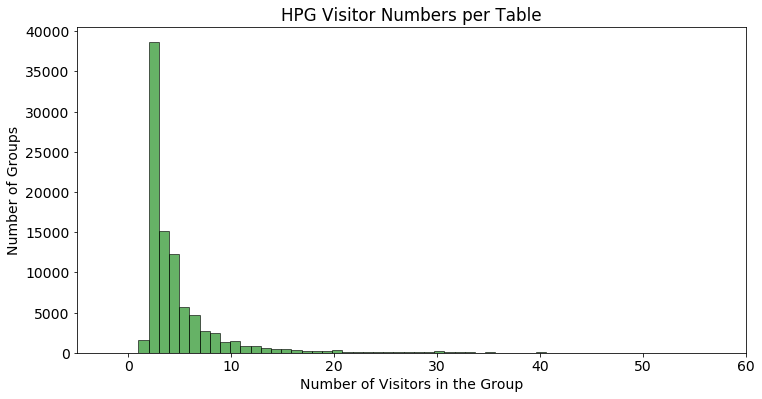

In [27]:
## Plot the HPG visitor numbers per reservation
plt.figure(figsize=(12,6))
plt.hist(air_reserve['reserve_visitors'], bins=100, color='g', alpha=0.6, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('HPG Visitor Numbers per Table')
plt.xlabel('Number of Visitors in the Group')
plt.ylabel('Number of Groups')
plt.xlim(-5, 60)
# plt.xticks(np.linspace(0, 60, 30))

In [28]:
## Add 'month' and 'year' columns 
air_visit['month'] = air_visit['visit_date'].apply(lambda x: x.month)
air_visit['year'] = air_visit['visit_date'].apply(lambda x: x.year)
rest_2016 = list(set(list(air_visit[air_visit['year']==2016]['air_store_id'])))
rest_2017 = list(set(list(air_visit[air_visit['year']==2017]['air_store_id'])))
# print (len(rest_2016))
# print (len(rest_2017))

In [29]:
air_visit_rest = air_visit.set_index(['air_store_id', 'year', 'month', 'visit_date'])
# air_visit.loc['air_ba937bf13d40fb24'].head()

In [30]:
air_visit_day = air_visit.set_index(['year', 'month','visit_date', 'air_store_id'])
avg_visitor_2017 = list(air_visit_day.loc[2017].groupby('visit_date').mean()['visitors'])
# avg_visitor_2017[:5]

In [31]:
daily_m_visitors = air_visit.groupby('visit_date').mean()['visitors']
visitor_stats = pd.DataFrame(air_visit.groupby('visit_date').var())
visitor_stats['mean'] = daily_m_visitors
visitor_stats.head()

,visitors,month,year,mean
visit_date,,,,
2016-01-01,477.276152,0.0,0.0,21.520833
2016-01-02,455.870968,0.0,0.0,28.000000
2016-01-03,560.256790,0.0,0.0,29.234568
2016-01-04,269.061816,0.0,0.0,21.184713
2016-01-05,156.608696,0.0,0.0,17.000000


In [32]:
visitor_stats['stdev'] = visitor_stats['visitors'].apply(lambda x: np.sqrt(x))
visitor_stats['stdev1'] = np.add(np.array(visitor_stats['mean']), np.array(visitor_stats['stdev']))
visitor_stats['stdev2'] = np.add(np.array(visitor_stats['mean']), 2*np.array(visitor_stats['stdev']))
visitor_stats['stdev3'] = np.add(np.array(visitor_stats['mean']), 3*np.array(visitor_stats['stdev']))
visitor_stats['stdev1n'] = np.subtract(np.array(visitor_stats['mean']), np.array(visitor_stats['stdev']))
visitor_stats['stdev2n'] = np.subtract(np.array(visitor_stats['mean']), 2*np.array(visitor_stats['stdev']))
visitor_stats['stdev3n'] = np.subtract(np.array(visitor_stats['mean']), 3*np.array(visitor_stats['stdev']))

In [33]:
visitor_stats.head()

,visitors,month,year,mean,stdev,stdev1,stdev2,stdev3,stdev1n,stdev2n,stdev3n
visit_date,,,,,,,,,,,
2016-01-01,477.276152,0.0,0.0,21.520833,21.846651,43.367484,65.214135,87.060786,-0.325817,-22.172468,-44.019119
2016-01-02,455.870968,0.0,0.0,28.000000,21.351135,49.351135,70.702270,92.053405,6.648865,-14.702270,-36.053405
2016-01-03,560.256790,0.0,0.0,29.234568,23.669744,52.904312,76.574056,100.243800,5.564824,-18.104920,-41.774665
2016-01-04,269.061816,0.0,0.0,21.184713,16.403104,37.587817,53.990921,70.394025,4.781610,-11.621494,-28.024598
2016-01-05,156.608696,0.0,0.0,17.000000,12.514340,29.514340,42.028679,54.543019,4.485660,-8.028679,-20.543019


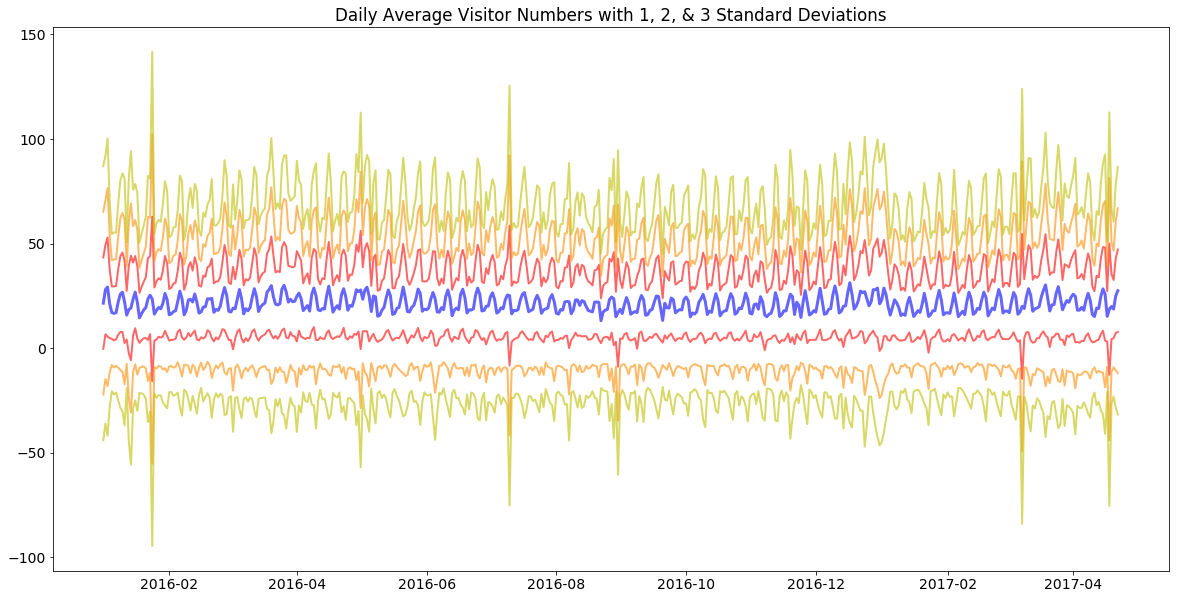

In [34]:
plt.figure(figsize=(20,10))
plt.plot(air_visit.groupby('visit_date').mean()['visitors'], linewidth=3, alpha=0.6\
        , color='b')
plt.plot(visitor_stats['stdev1'], color='r', linewidth=2, alpha=0.6)
plt.plot(visitor_stats['stdev2'], color='darkorange', linewidth=2, alpha=0.6)
plt.plot(visitor_stats['stdev3'], color='y', linewidth=2, alpha=0.6)
plt.plot(visitor_stats['stdev1n'], color='r', linewidth=2, alpha=0.6)
plt.plot(visitor_stats['stdev2n'], color='darkorange', linewidth=2, alpha=0.6)
plt.plot(visitor_stats['stdev3n'], color='y', linewidth=2, alpha=0.6)
plt.title('Daily Average Visitor Numbers with 1, 2, & 3 Standard Deviations')

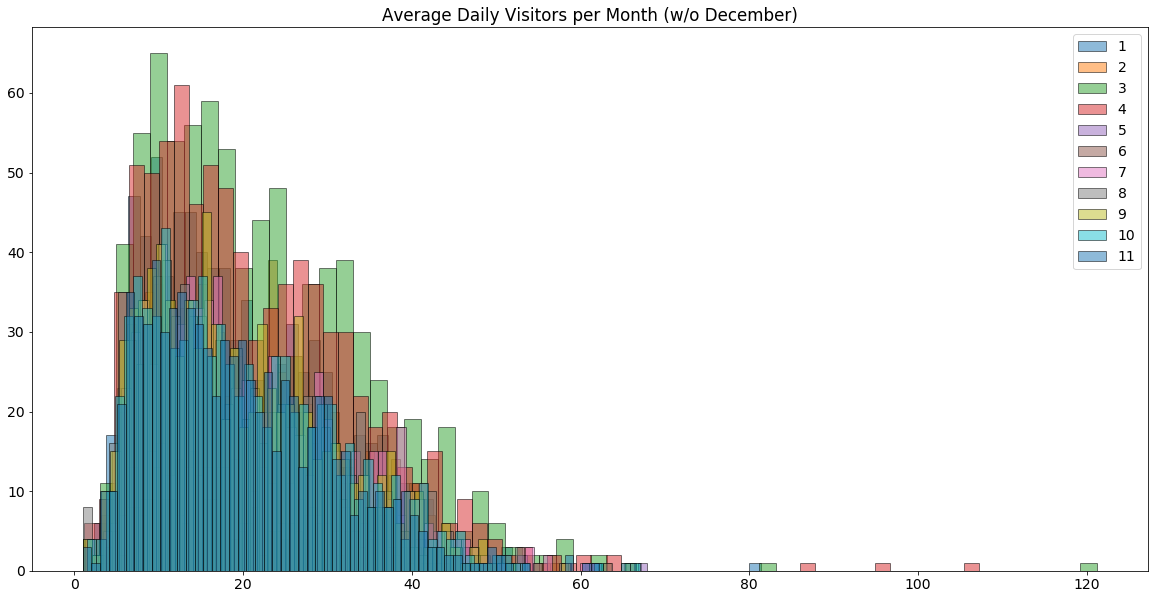

In [35]:
plt.figure(figsize=(20,10))
air_visit_month_avg = air_visit.groupby(['month', 'air_store_id']).mean()
plt.rcParams['font.size'] = 14
for i in range(1, 12):
    plt.hist(air_visit_month_avg.loc[i]['visitors'], bins=60, label=str(i), histtype='bar',\
            alpha=0.5, edgecolor='k')
    
plt.legend()
plt.title('Average Daily Visitors per Month (w/o December)')

# plt.angle_spectrum()

(-5, 200)

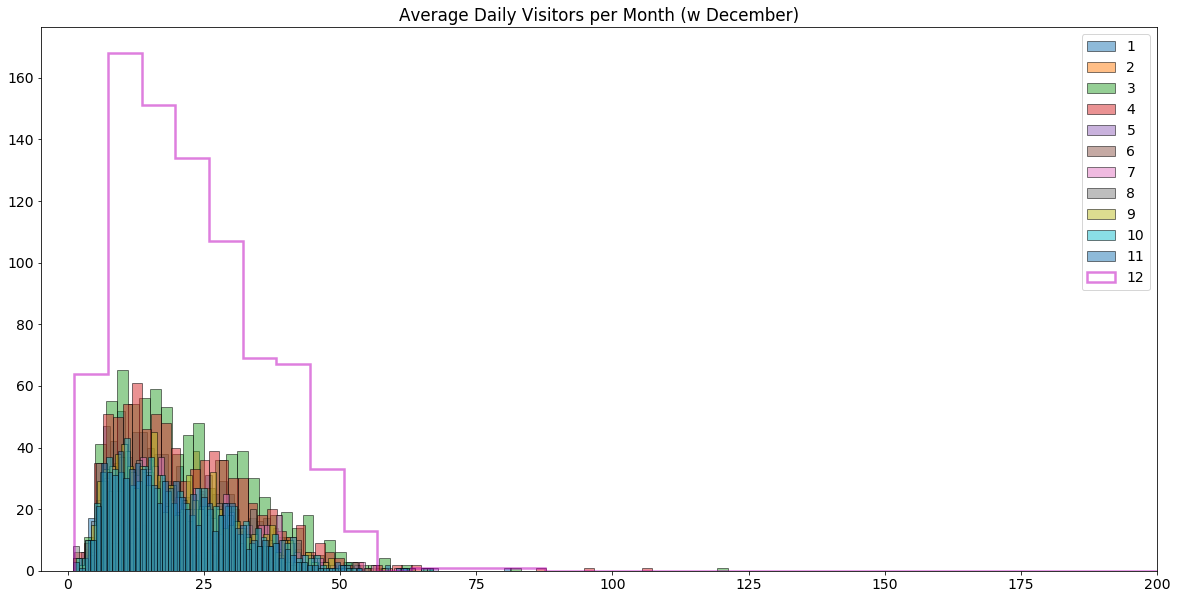

In [36]:
plt.figure(figsize=(20,10))
air_visit_month_avg = air_visit.groupby(['month', 'air_store_id']).mean()
plt.rcParams['font.size'] = 14
for i in range(1, 12):
    plt.hist(air_visit_month_avg.loc[i]['visitors'], bins=60, label=str(i), histtype='bar',\
            alpha=0.5, edgecolor='k')
plt.hist(air_visit_month_avg.loc[12]['visitors'], bins=60, label=str(12), histtype='step', linewidth=2.5,\
            alpha=0.5,color='m')
    
plt.legend()
plt.title('Average Daily Visitors per Month (w December)')
plt.rcParams['font.size'] = 12
plt.xlim(-5, 200)


In [37]:
### Is there sth wrong here?

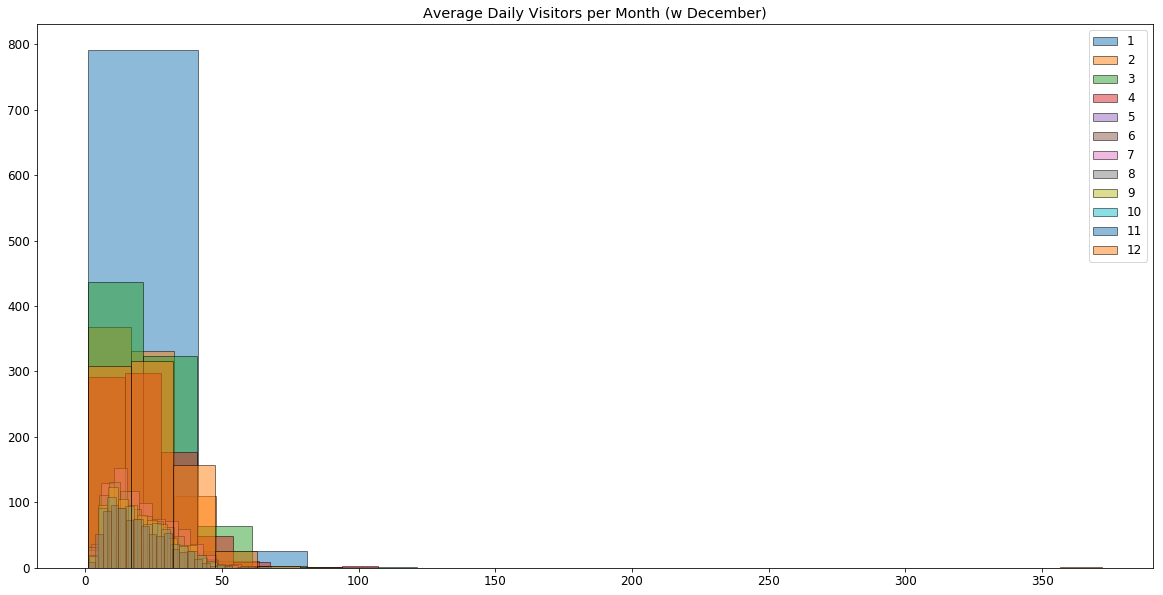

In [38]:
plt.figure(figsize=(20,10))
air_visit_month_avg = air_visit.groupby(['month', 'air_store_id']).mean()
for i in range(1, 13):
    plt.hist(air_visit_month_avg.loc[i]['visitors'],bins=i*2, label=str(i), histtype='bar',\
            alpha=0.5, edgecolor='k')
    
plt.legend()
plt.title('Average Daily Visitors per Month (w December)')
plt.rcParams['font.size'] = 12
# plt.xlim(-5, 200)

In [39]:
## Plot this to see whether there is a big difference in terms of overall numbers
month_avgs = []
month_stdevs = []
for month in range(1,13):
    month_avgs.append(np.mean(air_visit_month_avg.loc[month]['visitors']))
    month_stdevs.append(np.std(air_visit_month_avg.loc[month]['visitors']))

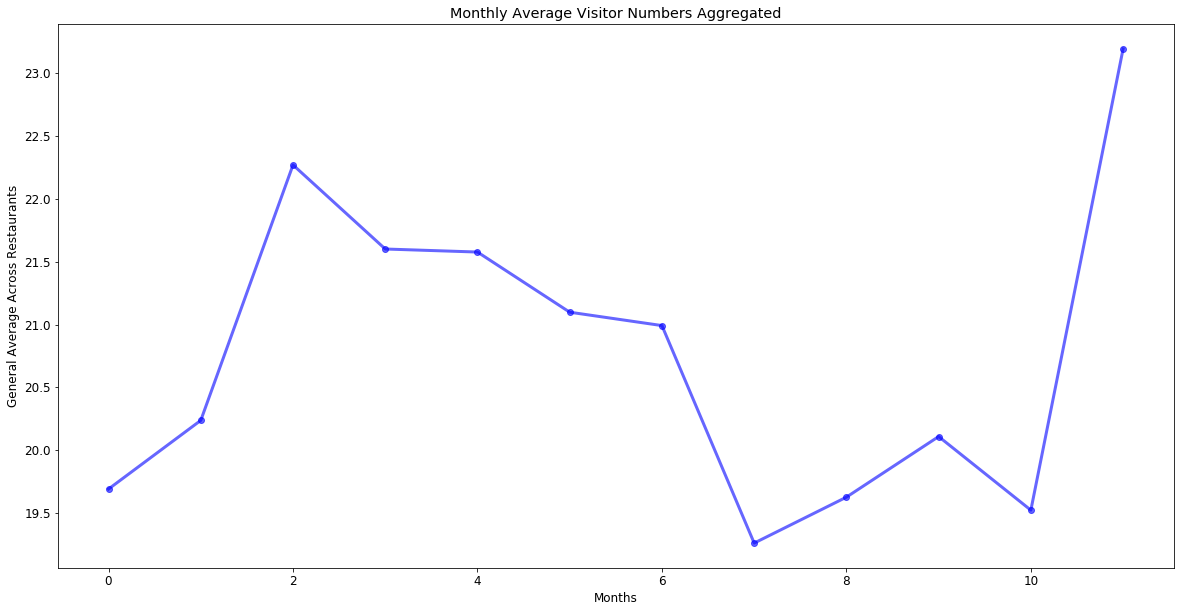

In [41]:
plt.figure(figsize=(20,10))
plt.plot(month_avgs, marker='o', linewidth=3, alpha=0.6, color='b')
plt.title('Monthly Average Visitor Numbers Aggregated')
plt.xlabel('Months')
plt.ylabel('General Average Across Restaurants')


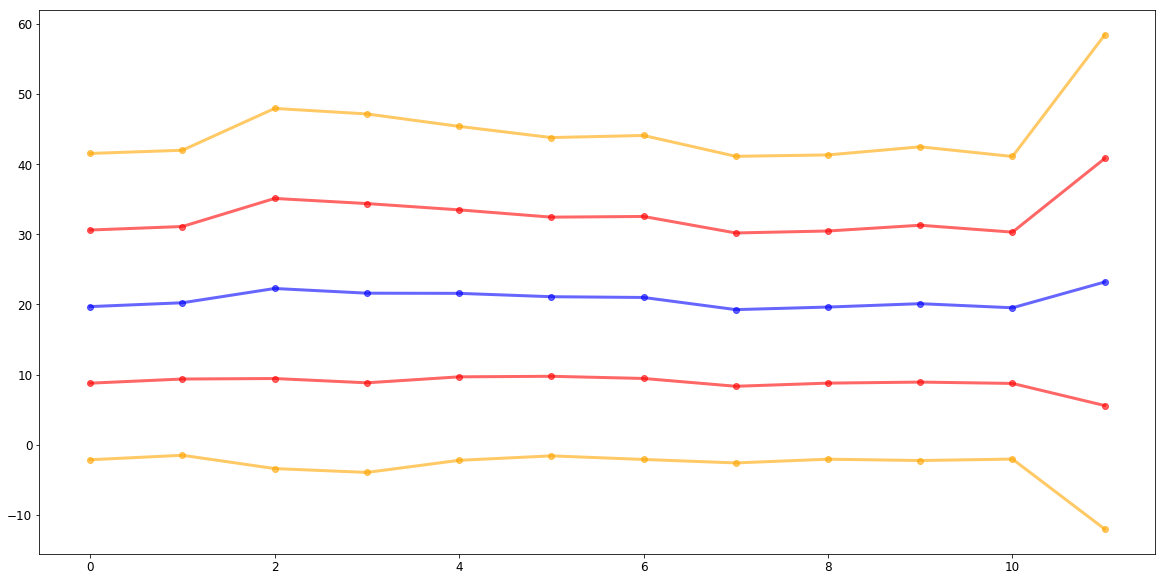

In [42]:
plt.figure(figsize=(20,10))
plt.plot(month_avgs, marker='o', linewidth=3, alpha=0.6, color='b')
plt.plot(np.add(month_avgs, month_stdevs),marker='o', linewidth=3, alpha=0.6, color='r')
plt.plot(np.subtract(month_avgs, month_stdevs),marker='o', linewidth=3, alpha=0.6, color='r')
plt.plot(np.add(month_avgs, 2*np.array(month_stdevs)),marker='o', linewidth=3, alpha=0.6, color='orange')
plt.plot(np.subtract(month_avgs, 2*np.array(month_stdevs)),marker='o', linewidth=3, alpha=0.6, color='orange')

/Users/derin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/derin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: PerformanceWarning:

indexing past lexsort depth may impact performance.



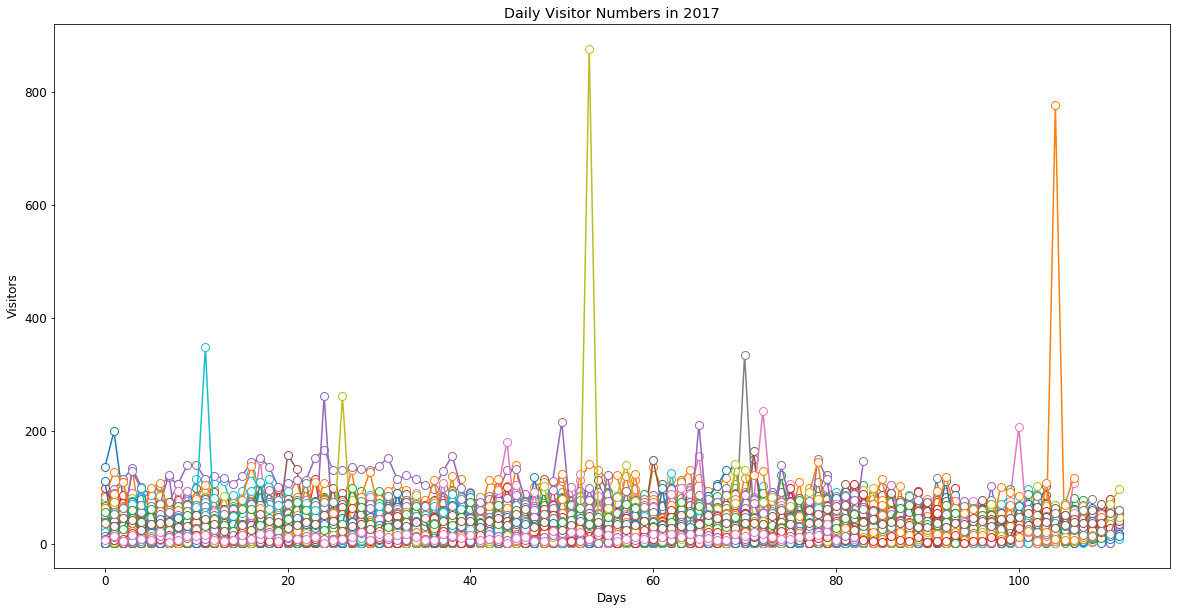

In [43]:
plt.figure(figsize=(20,10))
## plot the average number of visitors across all restaurants
# plt.plot(avg_num_visitor, linewidth=6, color='b')
day_avg = []

for rest in rest_2017:
    day_avg.append(np.average(np.array(air_visit_rest.loc[rest, 2017].groupby('visit_date').sum()['visitors'])))
    ## plot the total number of daily visitors for each restaurant
    plt.plot(np.array(air_visit_rest.loc[rest, 2017].groupby('visit_date').sum()['visitors']), marker='o', markersize=8, markerfacecolor='white',\
            linewidth=1.5, )
    
    plt.title('Daily Visitor Numbers in 2017')
    plt.xlabel('Days')
    plt.ylabel('Visitors')
    
# plt.plot(days_2017, day_avg, linewidth=6, color='b')

/Users/derin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: PerformanceWarning:

indexing past lexsort depth may impact performance.



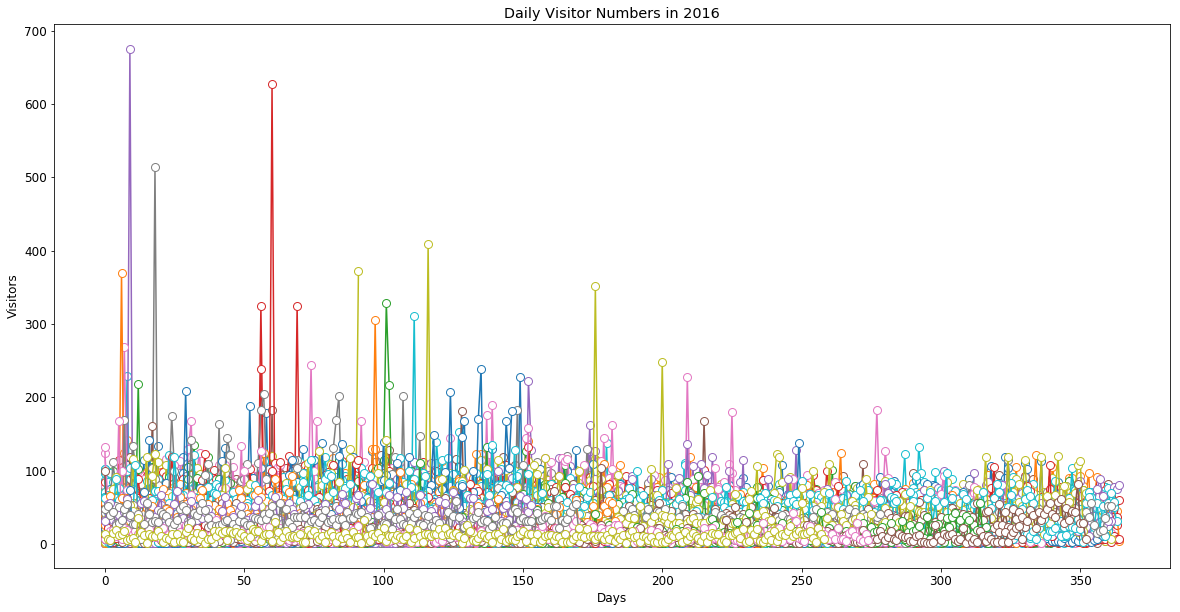

In [44]:
plt.figure(figsize=(20,10))
## plot the average number of visitors across all restaurants


for rest in rest_2016:
    ## plot the total number of daily visitors for each restaurant
    plt.plot(list(air_visit_rest.loc[rest, 2016]['visitors']), marker='o', markersize=8, markerfacecolor='white',\
            linewidth=1.5)
    plt.title('Daily Visitor Numbers in 2016')
    plt.xlabel('Days')
    plt.ylabel('Visitors')

In [73]:
air_visit_month_avg.head()

visitors     year
month air_store_id                            
1     air_00a91d42b08b08d9  25.869565  2017.00
      air_0164b9927d20bcc3  10.789474  2017.00
      air_0241aa3964b7f861   9.540000  2016.46
      air_0328696196e46f18   7.714286  2017.00
      air_034a3d5b40d5b1b1   5.733333  2017.00

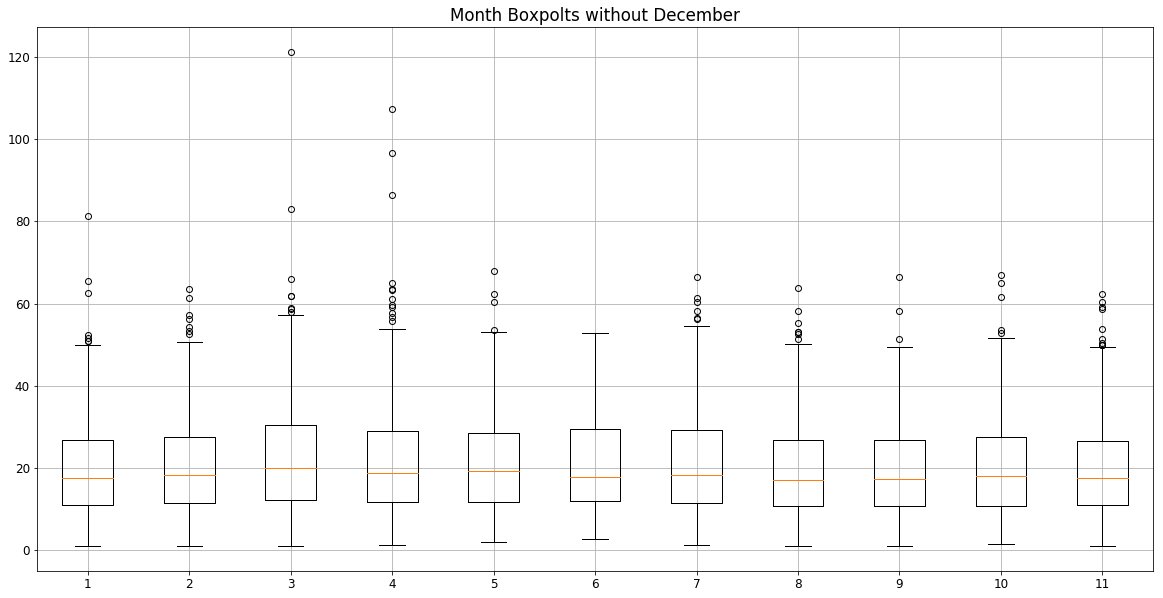

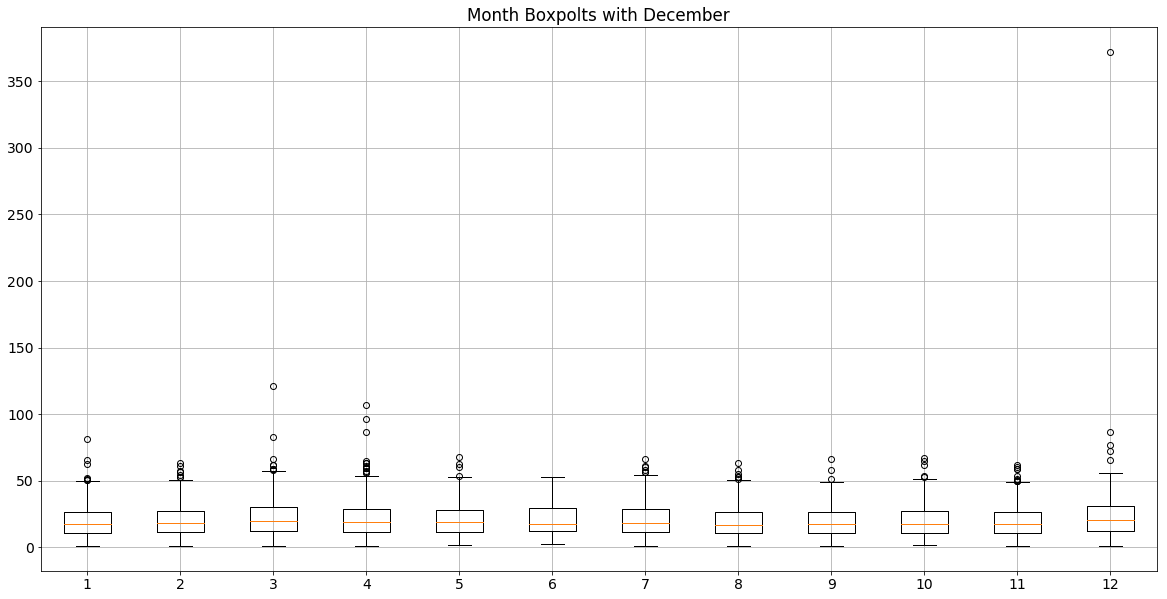

In [74]:

month_toplot = []
for month in range(1,13):
    month_toplot.append(air_visit_month_avg.loc[month]['visitors'])
plt.figure(figsize=(20,10))
plt.boxplot(month_toplot[:11])
plt.grid()
plt.rcParams['font.size'] = 14
plt.title('Month Boxpolts without December')

plt.figure(figsize=(20,10))
plt.boxplot(month_toplot)
plt.grid()
plt.rcParams['font.size'] = 14
plt.title('Month Boxpolts with December')

## Reservation Data

In [27]:
# working with air_reserve and hpg_reserve
print (air_reserve.columns)
print (hpg_reserve.columns)

Index(['air_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors'],
      dtype='object')
Index(['hpg_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors'],
      dtype='object')


(-5, 60)

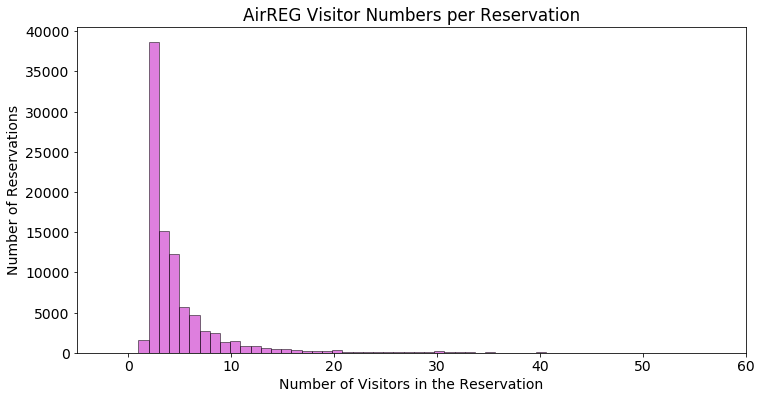

In [28]:
plt.figure(figsize=(12,6))
plt.hist(air_reserve['reserve_visitors'],bins=100, color='m', alpha=0.5, edgecolor='black')
# plt.hist(hpg_reserve['reserve_visitors'],bins=100, color='y', alpha=0.5, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('AirREG Visitor Numbers per Reservation')
plt.xlabel('Number of Visitors in the Reservation')
plt.ylabel('Number of Reservations')
plt.xlim(-5, 60)

(-5, 60)

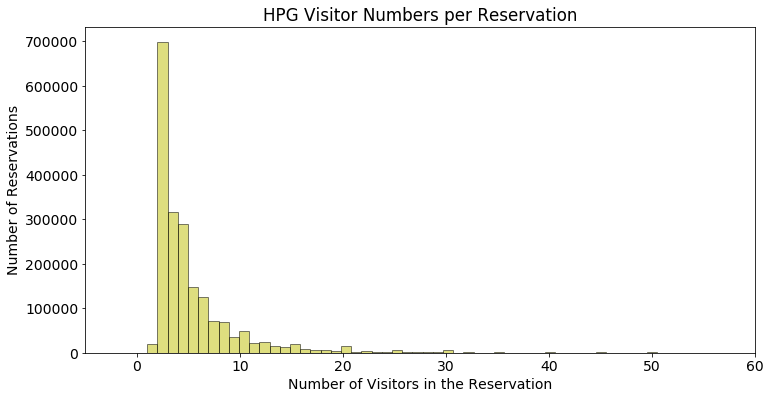

In [29]:
## Note the y values are much higher than AirREG's y values
plt.figure(figsize=(12,6))
plt.hist(hpg_reserve['reserve_visitors'],bins=100, color='y', alpha=0.5, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('HPG Visitor Numbers per Reservation')
plt.xlabel('Number of Visitors in the Reservation')
plt.ylabel('Number of Reservations')
plt.xlim(-5, 60)

# 2 Weather Data 

The weather data includes measurements from 1663 weather stations across Japan from January 2016 until May 2017 (in the "measurements" folder, along with 6 csv files. Those are,

1) __weather_stations__: The district name, the station names, altitude, and latitude, longitude information for each weather station.

2) __nearby_active_stations__: This data is the filtered version of the above weather\\ \_stations.

3) __air_station_distances__: This file contains the Vincenty distance of each weather station from each restaurant in the AirREGI data.

4) __hpg_station_distances__: This file contains the Vincenty distance of each weather station from each restaurant in the HPG data.

5) __air_store_info_with_nearest_active_station__: This file contains the following features for each store in AirREGI system: store ID, genre name, area name, latitude, longitude, closest station ID, station latitude, station longitude, closest station Vincenty distance, and closest station great circle distance.

6) __hpg_store_info_with_nearest_active_station__: This file contains the following features for each store in HPG system: store ID, genre name, area name, latitude, longitude, closest station ID, station latitude, station longitude, closest station Vincenty distance, and closest station great circle distance. 

Note: The distance units were not provided, but it was checked by us (below) and verified that the Vincenty and Great Circle distances are calculated for kilometers.

### Weather Stations

In [77]:
pd.DataFrame(pd.read_csv('data/rrv-weather-data/weather_stations.csv')).head()

,id,prefecture,first_name,second_name,latitude,longitude,altitude,date_terminated
0,aichi__ai-xi-kana__isaai,aichi,ai-xi-kana,isaai,35.216667,136.698333,5.0,NaN
1,aichi__aki-kana__azo,aichi,aki-kana,azo,35.078333,137.413333,613.0,NaN
2,aichi__centrair-kana__centrair,aichi,centrair-kana,centrair,34.858333,136.805000,4.0,NaN
3,aichi__chapel-mountain-kana__chaw-yama,aichi,chapel-mountain-kana,chaw-yama,35.220000,137.660000,1216.0,NaN
4,aichi__gamagori-kana__gamagori,aichi,gamagori-kana,gamagori,34.845000,137.216667,55.0,NaN


### Nearby Active Stations

In [78]:
pd.DataFrame(pd.read_csv('data/rrv-weather-data/nearby_active_stations.csv')).head()

,id,prefecture,first_name,second_name,latitude,longitude,altitude,date_terminated
0,fukuoka__dazaifu-kana__dasaif,fukuoka,dazaifu-kana,dasaif,33.496667,130.490000,52.0,NaN
1,fukuoka__fukuoka-kana__fukuoka,fukuoka,fukuoka-kana,fukuoka,33.581667,130.375000,2.5,NaN
2,fukuoka__hakata-kana__hakata,fukuoka,hakata-kana,hakata,33.583333,130.451667,9.0,NaN
3,fukuoka__iizuka-kana__ikka,fukuoka,iizuka-kana,ikka,33.651667,130.693333,37.1,NaN
4,fukuoka__kuroki-kana__kuroigi,fukuoka,kuroki-kana,kuroigi,33.225000,130.645000,144.0,NaN


### AirREGI Station Distances

In [79]:
pd.DataFrame(pd.read_csv('data/rrv-weather-data/air_station_distances.csv')).head()

,station_id,station_latitude,station_longitude,"(34.6951242, 135.1978525)","(35.6580681, 139.7515992)","(33.5892157, 130.3928134)","(35.6465721, 139.6532473)","(34.7053617, 135.5100252)","(35.6617773, 139.7040506)","(35.6995657, 139.6364379)",...,"(35.6593968, 139.6964402)","(35.7073985, 139.6638354)","(35.7322863, 139.710247)","(35.7081457, 139.666288)","(34.7660929, 135.6280998)","(35.6641222, 139.729426)","(43.0568187, 141.3539573)","(33.2119674, 130.5579082)","(34.6876966, 135.4954131)","(35.6532174, 139.7110363)"
0,aichi__ai-xi-kana__isaai,35.216667,136.698333,148.760474,281.515494,607.092649,272.519535,122.458285,277.332264,272.027251,...,276.609347,274.623848,279.264891,274.857241,109.752891,279.641615,958.556680,607.836336,124.564101,277.803513
1,aichi__aki-kana__azo,35.078333,137.413333,206.934423,222.009692,666.658179,213.104447,178.827179,217.995118,213.408094,...,217.259269,216.034963,220.890195,216.271701,166.759508,220.271694,948.829872,665.113006,180.605171,218.332602
2,aichi__centrair-kana__centrair,34.858333,136.805000,148.219287,282.425838,607.247882,273.551438,119.736543,278.447541,273.969304,...,277.710659,276.596655,281.470456,276.833511,108.166411,280.714921,991.479630,604.982787,121.363420,278.761144
3,aichi__chapel-mountain-kana__chaw-yama,35.220000,137.660000,232.290097,196.028930,692.042696,187.076948,204.483249,191.950202,187.129755,...,191.217373,189.752619,194.555239,189.988814,192.213288,194.241747,926.532369,691.125370,206.337505,192.333514
4,aichi__gamagori-kana__gamagori,34.845000,137.216667,185.551102,247.697421,643.912231,238.921222,156.985300,243.820606,239.699305,...,243.082615,242.322439,247.261222,242.559212,145.621391,246.058667,979.300432,640.934369,158.536737,244.071522


### HPG Station Distances

In [80]:
pd.DataFrame(pd.read_csv('data/rrv-weather-data/hpg_station_distances.csv')).head()

,station_id,station_latitude,station_longitude,"(35.6436746642265, 139.668220854814)","(34.8299255519268, 134.67307503026)","(35.6686002312873, 139.763042710922)","(33.576378885814, 130.339313030944)","(35.7049600607628, 139.828642317999)","(34.3921061951814, 132.461913549062)","(35.7504730896129, 139.668412382952)",...,"(34.3874999304076, 132.661308799626)","(34.8192452150664, 135.455217027399)","(35.2286300184325, 138.616270553172)","(37.838267244892, 139.104301421225)","(33.459353333184, 130.501845827137)","(34.5343100355169, 135.574890561587)","(37.5704782355036, 138.873286079977)","(33.6253345645257, 130.431896363042)","(43.4737679144369, 142.121081840925)","(37.9496613371687, 139.320881857858)"
0,aichi__ai-xi-kana__isaai,35.216667,136.698333,273.807155,189.740365,282.725621,612.251950,289.253536,398.263483,275.946323,...,380.665886,121.721628,174.611730,361.992653,602.451284,127.592239,326.005262,602.362086,1028.442446,383.450622
1,aichi__aki-kana__azo,35.078333,137.413333,214.313880,251.796992,223.331674,671.824800,230.175685,459.751286,217.965106,...,441.858496,181.155722,110.868817,341.702177,661.181614,178.717437,306.027812,662.058603,1016.291556,361.527761
2,aichi__centrair-kana__centrair,34.858333,136.805000,274.745122,195.009654,283.765888,612.414101,290.652680,401.582653,278.584673,...,383.540877,123.535588,170.286723,389.763469,601.466270,118.299929,353.750375,602.705152,1060.507816,410.570083
3,aichi__chapel-mountain-kana__chaw-yama,35.220000,137.660000,188.315295,275.990497,197.315052,697.208269,204.066820,484.364745,191.518327,...,466.582708,206.070761,87.062216,318.025164,686.816272,205.241088,282.616525,687.399839,993.369251,337.396234
4,aichi__gamagori-kana__gamagori,34.845000,137.216667,240.071397,232.657816,249.079769,649.076974,256.067699,438.899233,244.574215,...,420.815832,161.150492,134.613593,372.855680,637.885929,154.334072,337.111185,639.410354,1047.047395,392.808124


### AirREGI Stores with Nearest Active Station

In [81]:
pd.DataFrame(pd.read_csv('data/rrv-weather-data/air_store_info_with_nearest_active_station.csv')).head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835


### HPG Stores with Nearest Active Station

In [82]:
pd.DataFrame(pd.read_csv('data/rrv-weather-data/hpg_store_info_with_nearest_active_station.csv')).head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874


### Distance Unit Check

The unit information regarding the Vincenty and great circle distances is not given, and there is no indication in the data description on Kaggle. Let's check whether they are in kilometers or miles by using Vincenty.

In [83]:
from vincenty import vincenty
# (lat, long)
air_weather_merged = pd.DataFrame(pd.read_csv\
                                  ('data/rrv-weather-data/air_store_info_with_nearest_active_station.csv'))
station_try = (air_weather_merged.iloc[0]['station_latitude'],air_weather_merged.iloc[0]['station_longitude'])
restaurant_try = (air_weather_merged.iloc[0]['latitude'],air_weather_merged.iloc[0]['longitude'])
vincenty(station_try, restaurant_try, miles=False)

1.277232

Exactly the same as station_vincenty. The Vincenty and Great Circle formulas are used with kilometers in the data. Note: Elimninating one of them seems like a good idea, I'm used to working with vincenty. 

### The Actual Weather Measurements

In [84]:
## example measurement 
pd.DataFrame(pd.read_csv('data/rrv-weather-data/measurements/aichi__ai-xi-kana__isaai.csv')).head()

,Unnamed: 0,Unnamed: 0.1.1,calendar_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,avg_wind_speed
0,0,0,2016-01-01,6.0,11.0,0.7,0.0,9.1,2.9
1,1,1,2016-01-02,4.7,10.5,0.0,0.0,6.8,1.4
2,2,2,2016-01-03,7.0,13.8,1.9,0.0,8.6,1.4
3,3,3,2016-01-04,8.8,14.7,2.7,0.0,5.3,2.2
4,4,4,2016-01-05,8.9,14.1,3.4,0.0,4.5,2.7


We don't actually have any data for many columns including total_snowfall, avg_vapor_pressure etc. Dropping the columns, where all values are NaN from all measurement data. 

In [11]:
import os

In [12]:
def dropcols(data):
    data = data.dropna(axis=1, how='all')

In [13]:
## Writing all the measurements to a filelist (there are many measurements)
def air_station_list(path):
    file_list = os.listdir(path)[1:]
    return file_list

In [17]:
air_station_list('data/rrv-weather-data/measurements/') ## works

['aichi__ai-xi-kana__isaai.csv',
 'aichi__aki-kana__azo.csv',
 'aichi__centrair-kana__centrair.csv',
 'aichi__chapel-mountain-kana__chaw-yama.csv',
 'aichi__gamagori-kana__gamagori.csv',
 'aichi__horai-kana__horai____2002-12-24.csv',
 'aichi__ichinomiya-kana__ichinomiya.csv',
 'aichi__ikki-kana__ishiki.csv',
 'aichi__inake-kana__inab.csv',
 'aichi__iragaka-kana__iraco.csv',
 'aichi__kanie-kana__kanye.csv',
 'aichi__kayama-kana__dekiyama____2005-12-05.csv',
 'aichi__kohara-kana__obara.csv',
 'aichi__minamichita-kana__minamichita.csv',
 'aichi__nagoya-kana__nagoya.csv',
 'aichi__okazaki-kana__okazaki.csv',
 'aichi__oku-kana__oobu.csv',
 'aichi__shingo-castle__shinshiro.csv',
 'aichi__tahara-kana__tahala.csv',
 'aichi__tokai-kana__NONE____2012-10-17.csv',
 'aichi__toyama-kana__toyoyama____2005-02-17.csv',
 'aichi__toyohashi-kana__toyohashi.csv',
 'aichi__toyota-kana__toyota.csv',
 'aichi__writer-katakana__tsukodee.csv',
 'akita__ai-no-kana__aniayi.csv',
 'akita__akita-kana__akita.csv',
 '

In [16]:
## check nans
pd.DataFrame(pd.read_csv('data/rrv-weather-data/measurements/akita__akita-kana__akita.csv')).head(10)

## can get rid of unnamed0 and unnamed1, lots of cols for a lot of data

,Unnamed: 0,calendar_date,avg_temperature,high_temperature,low_temperature,hours_sunlight,solar_radiation,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
0,0,2016-01-01,2.3,4.3,-1.6,0.4,3.28,4.6,4.6,1022.8,65,1025.6,7.5
1,1,2016-01-02,3.9,8.3,0.7,0.2,1.56,3.9,6.8,1015.7,85,1018.4,10.0
2,2,2016-01-03,3.7,5.5,2.5,0.0,2.09,1.8,7.5,1014.0,94,1016.7,10.0
3,3,2016-01-04,2.3,3.9,1.1,0.5,2.82,3.2,6.2,1012.1,86,1014.8,10.0
4,4,2016-01-05,2.1,3.9,0.4,0.8,3.79,5.9,4.2,1016.4,59,1019.1,10.0
5,5,2016-01-06,1.9,3.9,0.7,0.3,2.86,3.8,5.0,1015.7,71,1018.4,10.0
6,6,2016-01-07,1.7,2.8,0.3,0.4,2.71,6.0,4.4,1011.2,64,1014.0,10.0
7,7,2016-01-08,1.8,3.2,0.0,0.1,2.51,4.2,4.8,1011.3,70,1014.0,10.0
8,8,2016-01-09,1.0,2.8,-0.7,1.5,5.72,4.9,4.4,1015.6,67,1018.4,9.8
9,9,2016-01-10,0.5,2.8,-1.7,0.3,3.87,6.0,4.6,1013.8,74,1016.6,10.0


In [92]:
## weather data actually needs cleaning, even after removing all-nan columns there are many differences 
## among data sets. For instance, the measurement data from different weather centers lack different columns.

In [93]:
## overwriting the csv files without the nan columns
for measurement_stat in air_station_list('data/rrv-weather-data/measurements/'): 
    ## get the full path
    station_path = 'data/rrv-weather-data/measurements/' + measurement_stat
    ## read each file to a df, drop nan cols and overwrite
    pd.DataFrame(pd.read_csv(station_path)).dropna(axis=1, how='any').to_csv(station_path, index=False)

In [94]:
## Use this while reading them from csv 
pd.DataFrame(pd.read_csv('data/rrv-weather-data/measurements/aichi__iragaka-kana__iraco.csv'))\
.set_index('Unnamed: 0', drop=True).isnull().any()

calendar_date         False
avg_temperature       False
high_temperature      False
low_temperature       False
hours_sunlight        False
avg_wind_speed        False
avg_local_pressure    False
avg_sea_pressure      False
dtype: bool

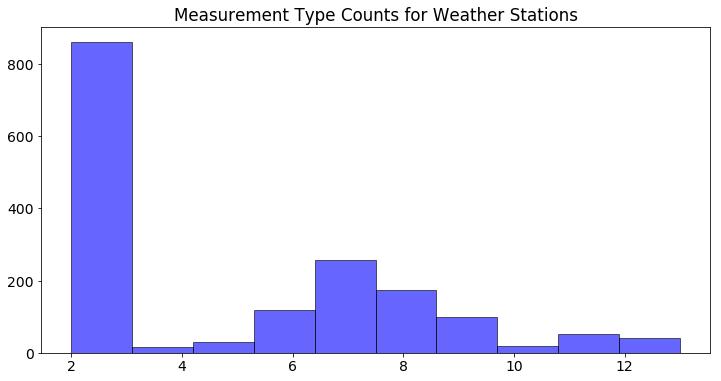

In [95]:
col_nums = []
## See if the number of columns the dfs contain are similar
for measurement_stat in air_station_list('data/rrv-weather-data/measurements/'):
    ## get the full path
    station_path = 'data/rrv-weather-data/measurements/' + measurement_stat
    ## check the number of columns in each csv and draw a histogram
    col_nums.append(len(pd.DataFrame(pd.read_csv(station_path)).columns.values))

plt.figure(figsize=(12,6))
plt.hist(col_nums, color='b', alpha=0.6, edgecolor='black')
plt.title('Measurement Type Counts for Weather Stations')

Using the 2-3 mutual columns (if they exist, otherwise just eliminating the weather center from the data) seems like a reasonable idea. We might have to extend our boundary limit for the restaurants that don't have any weather centers closeby. 

In [96]:
print ('In the data, there are measurements from ' + str(len(air_station_list('data/rrv-weather-data/measurements/'))) + ' weather stations in total.')

In the data, there are measurements from 1663 weather stations in total.


In [97]:
print ('The maximum number of measurement types from a weather center is ' + str(np.max(col_nums)) + '.')

The maximum number of measurement types from a weather center is 13.


In [98]:
## Collect the above histogram in a dict 
from collections import Counter
col_num_d = Counter(col_nums)
col_num_d

Counter({2: 529,
         3: 331,
         4: 16,
         5: 30,
         6: 119,
         7: 256,
         8: 174,
         9: 98,
         10: 19,
         11: 51,
         12: 12,
         13: 28})

In [6]:
air_rest_data = pd.DataFrame(pd.read_csv("merged_rest_data_weather_measurements.csv"))

In [9]:
air_rest_data.head()

,Unnamed: 0,1_closest_stat,2_closest_stat,3_closest_stat,4_closest_stat,5_closest_stat,air_store_id,avg_temperature1,day_of_week,high_temperature1,holiday_flg,hours_sunlight1,low_temperature1,precipitation1,visit_date,visitors
0,228949,tokyo__tokyo-kana__tonokyo,tokyo__edogawa-seaside-kana__edgawawinkai,tokyo__nerima-kana__nerima,tokyo__setagaya-kana__setagaya,tokyo__haneda-kana__haneda,air_0241aa3964b7f861,9.3,Sunday,16.2,1,8.3,3.0,NaN,2016-01-03,10
1,228950,tokyo__tokyo-kana__tonokyo,tokyo__edogawa-seaside-kana__edgawawinkai,tokyo__nerima-kana__nerima,tokyo__setagaya-kana__setagaya,tokyo__haneda-kana__haneda,air_0241aa3964b7f861,9.2,Monday,15.2,0,8.9,4.4,NaN,2016-01-04,9
2,228951,tokyo__tokyo-kana__tonokyo,tokyo__edogawa-seaside-kana__edgawawinkai,tokyo__nerima-kana__nerima,tokyo__setagaya-kana__setagaya,tokyo__haneda-kana__haneda,air_0241aa3964b7f861,10.9,Tuesday,15.4,0,8.4,5.1,NaN,2016-01-05,17
3,228952,tokyo__tokyo-kana__tonokyo,tokyo__edogawa-seaside-kana__edgawawinkai,tokyo__nerima-kana__nerima,tokyo__setagaya-kana__setagaya,tokyo__haneda-kana__haneda,air_0241aa3964b7f861,8.9,Wednesday,11.3,0,0.0,7.1,NaN,2016-01-06,10
4,228953,tokyo__tokyo-kana__tonokyo,tokyo__edogawa-seaside-kana__edgawawinkai,tokyo__nerima-kana__nerima,tokyo__setagaya-kana__setagaya,tokyo__haneda-kana__haneda,air_0241aa3964b7f861,6.8,Friday,10.9,0,8.7,3.1,NaN,2016-01-08,5


In [10]:
air_rest_data = air_rest_data.drop(["Unnamed: 0", "1_closest_stat",\
                                   "2_closest_stat", "3_closest_stat",\
                                   "4_closest_stat", "5_closest_stat",\
                                   "precipitation1"],1)

In [11]:
air_rest_data.head()

,air_store_id,avg_temperature1,day_of_week,high_temperature1,holiday_flg,hours_sunlight1,low_temperature1,visit_date,visitors
0,air_0241aa3964b7f861,9.3,Sunday,16.2,1,8.3,3.0,2016-01-03,10
1,air_0241aa3964b7f861,9.2,Monday,15.2,0,8.9,4.4,2016-01-04,9
2,air_0241aa3964b7f861,10.9,Tuesday,15.4,0,8.4,5.1,2016-01-05,17
3,air_0241aa3964b7f861,8.9,Wednesday,11.3,0,0.0,7.1,2016-01-06,10
4,air_0241aa3964b7f861,6.8,Friday,10.9,0,8.7,3.1,2016-01-08,5


In [14]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [15]:
air_rest_data_byrestindex = air_rest_data.set_index("air_store_id", drop=True)

In [17]:
air_rest_data_byrestindex.head()

,avg_temperature1,day_of_week,high_temperature1,holiday_flg,hours_sunlight1,low_temperature1,visit_date,visitors
air_store_id,,,,,,,,
air_0241aa3964b7f861,9.3,Sunday,16.2,1,8.3,3.0,2016-01-03,10
air_0241aa3964b7f861,9.2,Monday,15.2,0,8.9,4.4,2016-01-04,9
air_0241aa3964b7f861,10.9,Tuesday,15.4,0,8.4,5.1,2016-01-05,17
air_0241aa3964b7f861,8.9,Wednesday,11.3,0,0.0,7.1,2016-01-06,10
air_0241aa3964b7f861,6.8,Friday,10.9,0,8.7,3.1,2016-01-08,5


In [27]:
join_dict = {}
for rest in list(set(air_rest_data_byrestindex.index.values)):
    join_dict[rest] = pd.DataFrame(air_store[air_store["air_store_id"]==rest])


In [28]:
air_rest_data_byrestindex

,air_store_id,air_genre_name,air_area_name,latitude,longitude
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [32]:
def get_dict_join(data):
    genres = [list(join_dict[rest]["air_genre_name"])[0] for rest in data.index.values] 
    areas = [list(join_dict[rest]["air_area_name"])[0] for rest in data.index.values]
    data["genre"] = genres
    data["area_name"] = areas
    return data

In [33]:
rest_data_genre_area = get_dict_join(air_rest_data_byrestindex)

In [35]:
rest_data_genre_area.to_csv("final_merged_data.csv")

In [58]:
## train test splits
## separating March and April 2017 data as test set
from datetime import datetime
rest_data_genre_area["visit_date"] = rest_data_genre_area["visit_date"].\
    apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [60]:
## Testing behavior
datetime.strptime("2017-03-01", "%Y-%m-%d") > datetime.strptime("2018-03-01", "%Y-%m-%d")

False

In [63]:
# rest_data_genre_area.head()

In [92]:
day_of_week_df = pd.DataFrame(pd.get_dummies(rest_data_genre_area["day_of_week"]))

In [93]:
day_of_week_df.columns

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [95]:
for day in day_of_week_df.columns:
    rest_data_genre_area[day] = day_of_week_df[day]

In [97]:
genre_df = pd.DataFrame(pd.get_dummies(rest_data_genre_area["genre"]))


In [98]:
for genre in genre_df.columns:
    rest_data_genre_area[genre] = genre_df[genre]

In [103]:
len(rest_data_genre_area["area_name"].unique())

104

In [104]:
area_df = pd.DataFrame(pd.get_dummies(rest_data_genre_area["area_name"]))

In [105]:
for area in area_df.columns:
    rest_data_genre_area[area] = area_df[area]

In [106]:
rest_data_genre_area.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,area_name,avg_temperature1,day_of_week,...,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_0241aa3964b7f861,0,0,0,1,0,0,0,Tōkyō-to Taitō-ku Higashiueno,9.3,Sunday,...,0,0,0,0,0,0,0,0,0,0
air_0241aa3964b7f861,0,1,0,0,0,0,0,Tōkyō-to Taitō-ku Higashiueno,9.2,Monday,...,0,0,0,0,0,0,0,0,0,0
air_0241aa3964b7f861,0,0,0,0,0,1,0,Tōkyō-to Taitō-ku Higashiueno,10.9,Tuesday,...,0,0,0,0,0,0,0,0,0,0
air_0241aa3964b7f861,0,0,0,0,0,0,1,Tōkyō-to Taitō-ku Higashiueno,8.9,Wednesday,...,0,0,0,0,0,0,0,0,0,0
air_0241aa3964b7f861,1,0,0,0,0,0,0,Tōkyō-to Taitō-ku Higashiueno,6.8,Friday,...,0,0,0,0,0,0,0,0,0,0


In [109]:
## dropping the categorical columns after getting the dummies
rest_data_genre_area = rest_data_genre_area.drop(["area_name","genre","day_of_week"],1)

In [118]:
from statsmodels.tsa.arima_model import ARIMA

In [119]:
rest_data_genre_area["train_ind"] = rest_data_genre_area["visit_date"]\
.apply(lambda x: int(x< datetime.strptime("2017-03-01", "%Y-%m-%d")))

data_train = rest_data_genre_area[rest_data_genre_area["train_ind"]==1]
data_test = rest_data_genre_area[rest_data_genre_area["train_ind"]==0]

data_test[data_test.columns.values[:-1]].to_csv("data_test.csv")
data_train[data_train.columns.values[:-1]].to_csv("data_train.csv")

In [120]:
data_train = pd.DataFrame(pd.read_csv("data_train.csv"))
data_test = pd.DataFrame(pd.read_csv("data_test.csv"))

/Users/derin/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.



In [121]:
data_train.head()

,air_store_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,avg_temperature1,high_temperature1,...,Ōsaka-fu Neyagawa-shi Honmachi,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi
0,air_0241aa3964b7f861,0,0,0,1,0,0,0,9.3,16.2,...,0,0,0,0,0,0,0,0,0,0
1,air_0241aa3964b7f861,0,1,0,0,0,0,0,9.2,15.2,...,0,0,0,0,0,0,0,0,0,0
2,air_0241aa3964b7f861,0,0,0,0,0,1,0,10.9,15.4,...,0,0,0,0,0,0,0,0,0,0
3,air_0241aa3964b7f861,0,0,0,0,0,0,1,8.9,11.3,...,0,0,0,0,0,0,0,0,0,0
4,air_0241aa3964b7f861,1,0,0,0,0,0,0,6.8,10.9,...,0,0,0,0,0,0,0,0,0,0
